In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np 
import pandas as pd



        


In [3]:
import folium
import matplotlib.pyplot as plt 
import seaborn as sns 
import geopandas as gpd 
import math

In [4]:
#reading the csv files. 

df_BRT=pd.read_excel('D:\down\BRT & Non BRT Route Details & Bus Stop LatLong.xls',index_col=0,sheet_name='BRTS UNIQUE STOP NAME')
df_BRT
df_non_BRT=pd.read_excel('D:\down\BRT & Non BRT Route Details & Bus Stop LatLong.xls',sheet_name='Non BRTS UNIQUE STOP NAME')
route_name=pd.read_excel('D:\down\BRT & Non BRT Route Details & Bus Stop LatLong.xls',sheet_name=3)
short_route_name=pd.read_excel('D:\down\BRT & Non BRT Route Details & Bus Stop LatLong.xls',sheet_name='Short Rout name Satge')
route_des=pd.read_excel('D:\down\BRT & Non BRT Route Details & Bus Stop LatLong.xls',sheet_name='Route Description')

In [5]:
#Most the columns in these datasets are empty,so we'll only use these columns.
df_BRT=df_BRT.iloc[:,:4]
df_non_BRT=df_non_BRT.iloc[:,:3]
route_name=route_name.iloc[:,:9]




#the Latitude column in short_route_names is of type object.Converting that in float.
short_route_name['LAT']=short_route_name['LAT'].astype(float)

#converting the dtype of location coordinates.
route_name['LAT']=pd.to_numeric(route_name['LAT'],errors='coerce')
route_name['LONG']=pd.to_numeric(route_name['LONG'],errors='coerce')

In [6]:
#adding a new feature with the route id.

route_name['Route_id']=np.nan
for i in route_name.index:
    route_name['Route_id'][i]=str(route_name['Route'][i]).split('-')[0]

route_name.head()

<ipython-input-6-d52f2d13c463>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  route_name['Route_id'][i]=str(route_name['Route'][i]).split('-')[0]
D:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,Route Type,Route,Stop Code,Stop Seq,Stop Name,Stop Name Marathi,LAT,LONG,Stage,Route_id
0,BRTS,100-D,100-D-01,1,Hinjawadi Maan Phase 3,हिंजवडी माण फेज ३,18.576553,73.688178,1,100.0
1,BRTS,100-D,100-D-02,2,Tech Mahindra,टेक महेंद्रा,18.581016,73.687704,1,100.0
2,BRTS,100-D,100-D-03,3,Tata Motors,टाटा मोटर्स,18.586860,73.700098,2,100.0
3,BRTS,100-D,100-D-04,4,Power House Hinjawadi,पॉवर हाऊस हिंजवडी,18.588990,73.705400,2,100.0
4,BRTS,100-D,100-D-05,5,Infosys Phase 2,इन्फोसीस फेज 2,18.593741,73.708210,3,100.0


In [7]:
#How many bus routes are there in pune?(unique two way routes.)
route_name['Route_id'].nunique()

495

D:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'BusStop-type counts')

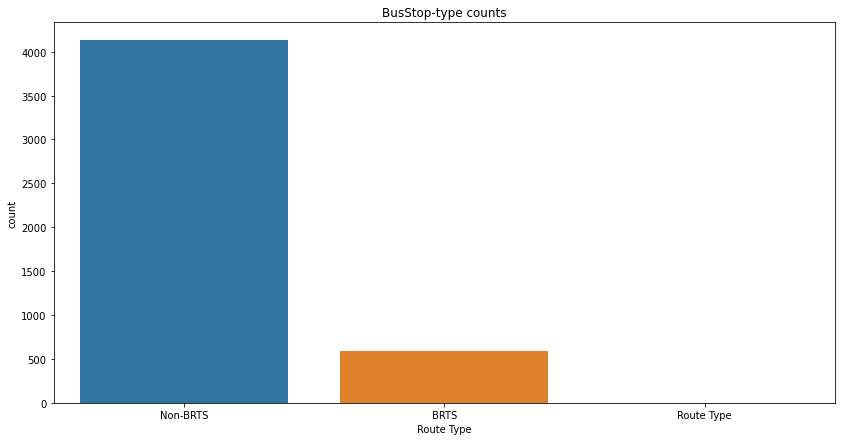

In [8]:
#lets see the count of bus stops labelled as BRT and non-BRT:
#there are duplicates so we'll introduce a new data set .
df_temp=pd.DataFrame()


for key,grp in route_name.groupby('Stop Name'):
    try:
        #most bus stops have stops on either side of the road so taking two values.
        ap=grp.iloc[:2]
    except:
        #some places (like bus depots) can have a single point as a Stop. 
        ap=grp.iloc[0]
    df_temp=df_temp.append(ap)


plt.figure(figsize=(14,7))    
sns.countplot(df_temp['Route Type'])
plt.title('BusStop-type counts')

In [9]:
#dropping Route 257-D and 8-U  from route name because they're showing anomalous data.
idx_to_drop=list(route_name[route_name['Route'] == '257-D'].index)
idx_to_drop.extend(route_name[route_name['Route']=='8-U'].index)
route_name.drop(idx_to_drop,inplace=True)

In [10]:
#creating a geopandas dataframe.

route_gdf=gpd.GeoDataFrame(route_name,geometry=gpd.points_from_xy(route_name['LONG'],route_name['LAT']),crs=4326)
# route_gdf.set_crs(epsg=3857)
#mercator
route_gdf['geometry'].to_crs(epsg=4326)

0        POINT (73.68818 18.57655)
1        POINT (73.68770 18.58102)
2        POINT (73.70010 18.58686)
3        POINT (73.70540 18.58899)
4        POINT (73.70821 18.59374)
                   ...            
34084    POINT (73.82232 18.55601)
34085                  POINT EMPTY
34086                  POINT EMPTY
34087                  POINT EMPTY
34088                  POINT EMPTY
Name: geometry, Length: 34017, dtype: geometry

In [11]:
route_gdf.reset_index(drop=True)

,Route Type,Route,Stop Code,Stop Seq,Stop Name,Stop Name Marathi,LAT,LONG,Stage,Route_id,geometry
0,BRTS,100-D,100-D-01,1,Hinjawadi Maan Phase 3,हिंजवडी माण फेज ३,18.576553,73.688178,1,100.0,POINT (73.68818 18.57655)
1,BRTS,100-D,100-D-02,2,Tech Mahindra,टेक महेंद्रा,18.581016,73.687704,1,100.0,POINT (73.68770 18.58102)
2,BRTS,100-D,100-D-03,3,Tata Motors,टाटा मोटर्स,18.586860,73.700098,2,100.0,POINT (73.70010 18.58686)
3,BRTS,100-D,100-D-04,4,Power House Hinjawadi,पॉवर हाऊस हिंजवडी,18.588990,73.705400,2,100.0,POINT (73.70540 18.58899)
4,BRTS,100-D,100-D-05,5,Infosys Phase 2,इन्फोसीस फेज 2,18.593741,73.708210,3,100.0,POINT (73.70821 18.59374)
...,...,...,...,...,...,...,...,...,...,...,...
34012,Non-BRTS,13C-U,13C-U-29,29,Pune Vidhyapeeth,पुणे विद्यापीठ,18.556015,73.822317,10,13C,POINT (73.82232 18.55601)
34013,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nan,POINT EMPTY
34014,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nan,POINT EMPTY
34015,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nan,POINT EMPTY


In [23]:
# lat_conv=110.574 #km
# long_conv=111.320 * np.cos(lat)

# Point.
from shapely.geometry import Point

#for displaying the map
from IPython.display import HTML,display


def closest_Bus_stop(lat,long):
    point=Point(long,lat)
    min_idx=np.argmin(route_gdf.geometry.distance(point))
#     min_idx=route_gdf.geometry.distance((point)).idxmin
    
    #finding the closest bus stop.
    bs=route_gdf.iloc[min_idx]
    name=bs['Stop Name']
    dis=np.sqrt((abs(lat-bs['LAT'])*110.574)**2 + ((abs(long-bs['LONG'])*(111.320)*np.cos(lat))**2))      #aerial distance
      #plotting the map and the points.
    m=folium.Map(location=[lat,long], tiles='Open Street Map', zoom_start=13,min_zoom=9)
    folium.Marker(location=[lat,long],tooltip=f'<b> Current Location </b>',icon=folium.Icon(color='blue',icon='home')).add_to(m)
    folium.Marker(location=[bs['LAT'],bs['LONG']],tooltip=f'<b> {name} </b>',icon=folium.Icon(color='green',icon='info-sign')).add_to(m)
    
    
    print(f'{name} is {dis} km away.')
    display(m)

In [13]:
#Here just by droping our current logitutde and latitude we see our nearest bus stop


predict=closest_Bus_stop(18.5216668,73.8296012)

<ipython-input-12-319e6d20d7cc>:13: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  min_idx=np.argmin(route_gdf.geometry.distance(point))


Symbiosis College is 0.059986136987301035 km away.


In [15]:
closest_Bus_stop(18.511630262925806, 73.81398389278067)

<ipython-input-12-319e6d20d7cc>:13: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  min_idx=np.argmin(route_gdf.geometry.distance(point))


Anandnagar Kothrud is 0.21090286749577025 km away.


In [ ]:
Thanks

